In [1]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from typing import Callable, List

%config InlineBackend.figure_format = 'svg'

# Temporal Point Process

时间点过程（Temporal Point Process，TPP）是用于建模随机事件序列的一类随机过程模型。它可以通过如下的方式来描述

* **事件时间序列**：设$T_i$为第$i$个事件发生的时间，且$T_i$满足$0=T_0<T_1<T_2<...<T_n$。
* **间隔时间序列**：设$S_i=T_i-T_{i-1}$为第$i$个事件与前一个事件之间的时间间隔，且$S_i$满足$S_1>0, S_2>0, ..., S_n>0$。
* **计数过程**：设$N(t)$为在时间区间$[0, t]$发生的事件的数量，即$N(t)=\sum_{i=1}^n I(T_i\leq t)$，其中$I(\cdot)$为指示函数。

假设事件的发生相互关联，定义$\mathcal H_t$为在时间$t$及时间$t$之前发生的事件的集合，即$\mathcal H_t=\{t_i|t_i\leq t\}$，以及$\mathcal H_{t-}$为时间$t$之前发生的事件的集合，即$\mathcal H_{t^-}=\{t_i|t_i<t\}$。如果用事件时间序列的方式来建模点过程，则所有事件发生时间的联合分布为

$$
f(t_1, t_2, ..., t_n) = \prod_{i=1}^n f(t_i\mid \mathcal H_{T_{i-1}})
$$

强度函数$\lambda(t\mid \mathcal H_{t_{n}})$定义了在给定历史发生的$n$个事件后，下一个事件发生的速率。

$$
\begin{aligned}
\lambda (t\mid \mathcal H_{t_{n}})\mathrm d t &= \frac{f(t\mid \mathcal H_{t_{n}})\mathrm d t}{1 - F(t\mid \mathcal H_{t_{n}})} \\
&= \frac{P(t_{n + 1}\in [t, t + \mathrm d t]\mid \mathcal H_{t_{n}})}{P(t_{n + 1}\geq t\mid \mathcal H_{t_{n}})} \\
&= P(t_{n + 1}\in [t, t + \mathrm d t]\mid \mathcal H_{t_{n}}, t_{n + 1}\geq t) \\
&= P(t_{n + 1}\in [t, t + \mathrm d t], t_{n + 1}\geq t\mid \mathcal H_{t_{n}}) \\
&= \mathbb E \left[N(t + \mathrm d t) - N(t)\mid \mathcal H_{t_{n}^-} \right] \\
\end{aligned}
$$

强度函数$\lambda$和概率密度函数$f$构成双射关系：

$$
\begin{aligned}
F(t \mid \mathcal H_{t_{n}}) &= 1 - \exp\left[-\int_{t_n}^t \lambda(u\mid \mathcal H_{t_{n}})\mathrm d u\right] \\
f(t \mid \mathcal H_{t_{n}}) &= \lambda(t\mid \mathcal H_{t_{n}})\exp\left[-\int_{t_n}^t \lambda(u\mid \mathcal H_{t_{n}})\mathrm d u\right] \\
\end{aligned}
$$

In [2]:
def generate_sequence(
    lambda_: Callable[[float, np.ndarray], float],
    start_time: float = 0, end_time: float = 20, step: float = 0.001
):
    '''
    Generate a sequence of events based on a given TPP intensity function
    '''
    history = np.empty(int((end_time - start_time) // step), dtype=float)
    intensity = []
    time = []
    num_history = 0
    t = start_time

    while t < end_time:
        time.append(t)
        intensity.append(lambda_(t, history[:num_history]))
        p = intensity[-1] * step
        if p > 0 and np.random.rand() < p:
            history[num_history] = t
            num_history += 1
        t += step

    return history[:num_history], np.array(intensity), np.array(time)

def plot_sequence(
    *lambdas: Callable[[float, np.ndarray], float],
    start_time: float = 0, end_time: float = 20, step: float = 0.001,
    labels: List[str] | None = None
):
    fig, (ax_i, ax_e) = plt.subplots(
        2, 1, figsize=(10, 5 + 0.75 * len(lambdas)), sharex=True,
        height_ratios=[5, 0.75 * len(lambdas)]
    )
    if labels is None:
        labels = [f'{_}' for _ in range(len(lambdas))]
    for i, lambda_ in enumerate(lambdas):
        history, intensity, time = generate_sequence(lambda_, start_time, end_time, step)
        ax_e.plot(
            history, [i] * len(history), 'o', alpha=0.5, markersize=10,
            label=labels[i] if labels else None
        )
        ax_i.plot(
            time, intensity,
            label=labels[i] if labels else None
        )

    ax_i.legend()
    ax_i.set_ylabel('Intensity')

    ax_e.set_yticks(range(len(lambdas)))
    ax_e.set_yticklabels(labels)
    ax_e.set_xlabel('Time')
    ax_e.set_xlim(start_time, end_time)
    ax_e.grid(True, axis='x')
    ax_e.set_title('Generated Sequences')
    return fig, (ax_i, ax_e)

常见的TPP包含

* 泊松过程：强度函数为常数。
  $$
  \lambda(t\mid \mathcal H_{t_{n}})=\lambda
  $$

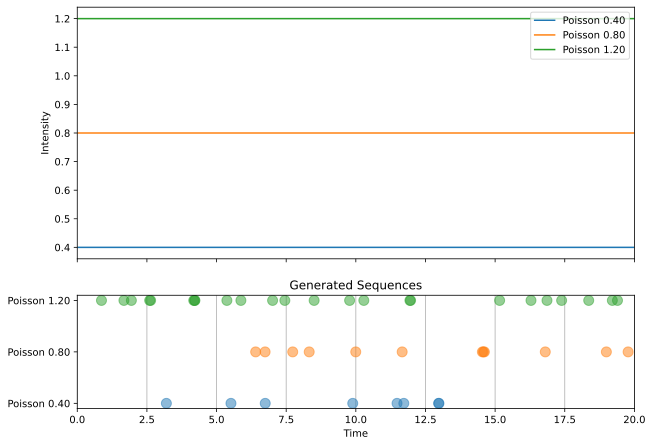

In [3]:
def poisson_intensity(lambda_: float) -> float:
    return lambda_

plot_sequence(
    lambda t, h: poisson_intensity(0.4),
    lambda t, h: poisson_intensity(0.8),
    lambda t, h: poisson_intensity(1.2),
    labels=[f'Poisson {_ * 0.4:.2f}' for _ in range(1, 4)],
)
plt.show()

* 更新过程：更新过程的间隔时间$S_i$是独立同分布的服从任意分布的随机变量。
  $$
  \lambda(t\mid \mathcal H_{t_{n}}) = \frac{f(t - t_n)}{1 - F(t - t_n)}
  $$

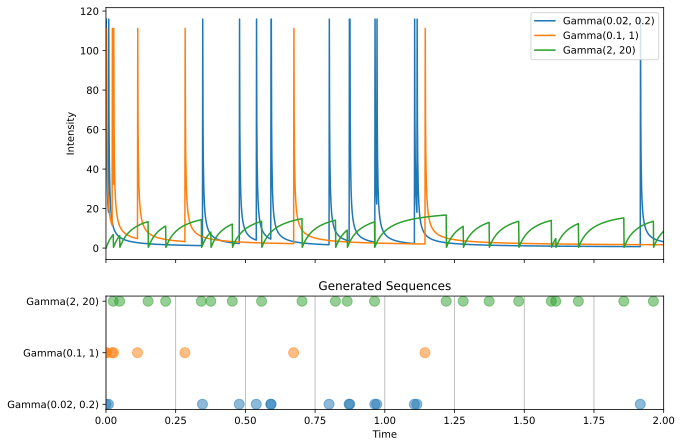

In [4]:
gammas = [
    stats.gamma(0.02, scale=1 / 0.2),
    stats.gamma(0.1, scale=1 / 1),
    stats.gamma(2, scale=1 / 20),
]
def gamma_intensity(t: float, history: np.ndarray, gamma) -> float:
    if history.size == 0:
        return gamma.pdf(t) / (1 - gamma.cdf(t))
    return gamma.pdf(t - history[-1]) / (1 - gamma.cdf(t - history[-1]))
plot_sequence(
    lambda t, h: gamma_intensity(t, h, gammas[0]),
    lambda t, h: gamma_intensity(t, h, gammas[1]),
    lambda t, h: gamma_intensity(t, h, gammas[2]),
    labels=['Gamma(0.02, 0.2)', 'Gamma(0.1, 1)', 'Gamma(2, 20)'], end_time=2
)
plt.show()

* Hawkes过程：强度函数为历史事件的线性组合。
  $$
  \lambda(t\mid \mathcal H_{t_{n}}) = \mu + \sum_{i=1}^{n} \phi(t - T_i)
  $$
  其中$\mu$为基线强度，$\phi(t - t_i)$为历史事件的影响函数，要求$\int_0^\infty \phi(t) \mathrm d t < 1$，常用的影响函数有指数衰减函数$\phi(t) = \alpha \exp(-\beta t)$和幂函数$\phi(t) = \alpha t^{-\beta}$。Hawkes过程是自激励的，即历史事件会增强未来事件发生的概率。

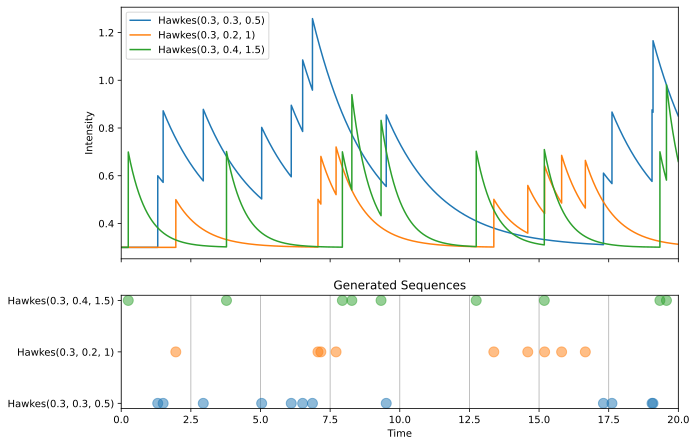

In [5]:
def hawkes_intensity(t: float, history: np.ndarray, mu: float, alpha: float, beta: float) -> float:
    return mu + alpha * np.sum(np.exp(-beta * (t - history)))


plot_sequence(
    lambda t, h: hawkes_intensity(t, h, 0.3, 0.3, 0.5),
    lambda t, h: hawkes_intensity(t, h, 0.3, 0.2, 1),
    lambda t, h: hawkes_intensity(t, h, 0.3, 0.4, 1.5),
    labels=['Hawkes(0.3, 0.3, 0.5)', 'Hawkes(0.3, 0.2, 1)', 'Hawkes(0.3, 0.4, 1.5)'],
)
plt.show()

## 标记点过程

当整个序列中会发生不同类型的事件时，TPP可以扩展为标记点过程（Marked Temporal Point Process，MTPP）。设$T_i$为第$i$个事件发生的时间，$X_i$为第$i$个事件的类型，则标记点过程的联合分布为

$$
f((t_1, x_1), (t_2, x_2), ..., (t_n, x_n)) = \prod_{i=1}^n f(t_i, x_i\mid \mathcal H_{t_{i-1}})
$$